In [1]:
%matplotlib inline

%env http_proxy=http://proxyserv:3128
%env https_proxy=http://proxyserv:3128

import os, re
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import warnings
from scipy import signal, stats
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.decomposition import PCA

# Make inline plots vector graphics instead of raster graphics
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')
#set_matplotlib_formats('pdf', 'svg')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

import geneinfo as gi
gi.email('kaspermunch@birc.au.dk')

import seaborn as sns
sns.set() # sets seaborn default "prettyness:
sns.set_style("white")
sns.set_context("notebook")

env: http_proxy=http://proxyserv:3128
env: https_proxy=http://proxyserv:3128


In [198]:
csv_files = ! ls ../info_asym/*chrX.csv 

df_list = []
for csv_file in csv_files:
    trio = re.search('(.*)_chr\S.csv', os.path.basename(csv_file)).group(1)
    df = pd.read_csv(csv_file)
    df['prop_ils'] = (df.V2 +  df.V3) / (df.V0 +  df.V1 + df.V2 +  df.V3)
    df['trio'] = trio
    df['start'] = df['position']
    df['end'] = df['position'] + 100000
    df_list.append(df)
all_ils_windows = pd.concat(df_list)
all_ils_windows.head()

,position,V0,V1,V2,V3,prop_ils,trio,start,end
0,200000,0,1055,0,1232,0.538697,AOTNAN_SAGMID_CEBALB_HOMSAP,200000,300000
1,300000,437,4828,5321,7401,0.707289,AOTNAN_SAGMID_CEBALB_HOMSAP,300000,400000
2,400000,30,824,1047,719,0.674046,AOTNAN_SAGMID_CEBALB_HOMSAP,400000,500000
3,600000,1122,2330,4314,2634,0.668077,AOTNAN_SAGMID_CEBALB_HOMSAP,600000,700000
4,800000,0,553,492,680,0.679420,AOTNAN_SAGMID_CEBALB_HOMSAP,800000,900000


In [205]:
ils_windows = all_ils_windows.groupby('trio').filter(lambda df: (df.prop_ils.mean() > 0.1) & (df.prop_ils.mean() < 0.4))
ils_windows.trio.unique()

max_quantile = 0.05
min_span = 2

# ils_windows['low_ils'] = ils_windows.groupby('trio').prop_ils.apply(lambda x: x <= x.quantile(max_quantile))
ils_windows['low_ils'] = ils_windows.groupby('trio').prop_ils.apply(lambda x: x <= 0.1 * x.mean())
# ils_windows['low_ils'] = ils_windows.groupby('trio').prop_ils.apply(lambda x: x <= 0.05)

# ils_windows['low_ils'] = ils_windows.prop_ils <= 0.1

runs = (ils_windows.low_ils != ils_windows.low_ils.shift(1)).cumsum()

counts_df = (ils_windows
             .groupby(runs)
           .filter(lambda df: df.shape[0] >= min_span and df.low_ils.mean() == 1)
           .groupby(['start', 'end'])
           .size()
           .to_frame('nrtrios')
           .reset_index()
          )
counts_df.shape[0]
#counts_df.head()

332

In [206]:
#ils_windows.groupby('trio').prop_ils.mean()

In [207]:
#ils_windows.groupby('trio').prop_ils.agg(lambda x: x.quantile(0.05))

In [208]:
counts_df = ils_windows[['start', 'end']].merge(counts_df, how='left')
counts_df['nrtrios'] = counts_df.nrtrios.replace(np.nan, 0)

In [209]:
%matplotlib widget

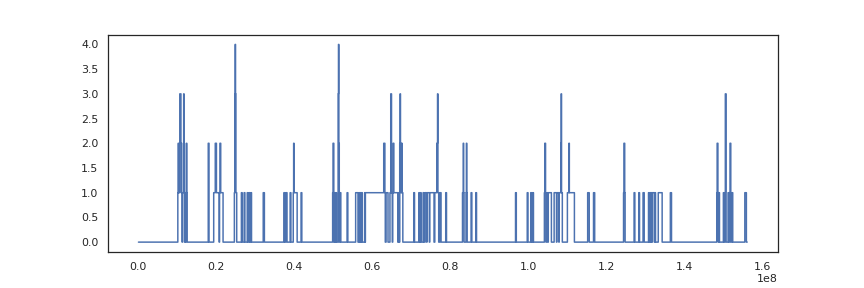

In [210]:
plot_df = (pd.concat([counts_df.copy().assign(pos=counts_df.start), 
                      counts_df.copy().assign(pos=counts_df.end)])
           .sort_values(['start', 'end'])
          )
plt.figure(figsize=(12, 4))
plt.plot(plot_df.pos, plot_df.nrtrios) ;
# plt.fill_between(plot_df.pos, plot_df.nrtrios)
#plt.xlim(45000000, 55000000)

In [138]:
plot_df

,start,end,nrtrios,pos
0,10100000,10200000,1,10100000
0,10100000,10200000,1,10200000
1,10200000,10300000,2,10200000
1,10200000,10300000,2,10300000
2,10300000,10400000,1,10300000
...,...,...,...,...
335,155600000,155700000,1,155700000
336,155700000,155800000,1,155700000
336,155700000,155800000,1,155800000
337,155800000,155900000,1,155800000


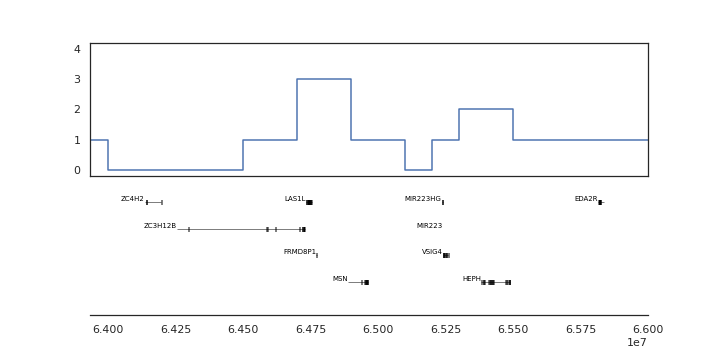

In [219]:
plot_df = (pd.concat([counts_df.copy().assign(pos=counts_df.start), 
                      counts_df.copy().assign(pos=counts_df.end)])
           .sort_values(['start', 'end'])
          )

ax = gi.gene_plot('chrX', 64000000, 66000000, assembly='hg19', figsize=(10,5))
ax.plot(plot_df.pos, plot_df.nrtrios) ; 

# BSN gene

# DOCK3 gene associated with ADHD